# Value at Risk (VaR) and Conditional VaR (CVaR)

In this notebook we compute two popular risk measures:

- **Value at Risk (VaR)**
- **Conditional VaR (CVaR)**, also called Expected Shortfall

We use daily historical data for a small stock portfolio and:

1. Compute **historical VaR and CVaR** from portfolio portfolio_portfolio_portfolio_portfolio_portfolio_portfolio_portfolio_portfolio_portfolio_portfolio_portfolio_portfolio_portfolio_portfolio_returns  
2. Compute **parametric VaR and CVaR** assuming
   - a **Normal** distribution
   - a **Student-t** distribution  
3. Use simple **Monte Carlo simulations** based on the fitted distributions  
4. Briefly explore the effect of **asset correlations** using a meanltivariate
   normal model

we explicitly include correlations using a **multivariate** normal model.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf
import seaborn as sns
import statsmodels.api as sm
plt.style.use("default")

## 1. Data: prices and portfolio returns

We pick a few large US tech stocks, download daily **adjusted close** prices
using `yfinance`, compute **daily returns**, and then form a simple
fixed-weight portfolio.

We will use the portfolio **daily return series** as the basis for VaR and
CVaR.


In [3]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2010-01-01'
end_date = '2019-12-01'

data = yf.download(tickers, start=start_date, end=end_date,auto_adjust=True)
prices = data["Close"].dropna()  # adjusted close prices

print("Prices shape:", prices.shape)
prices.tail()


[*********************100%***********************]  5 of 5 completed

Prices shape: (2495, 5)


Ticker,AAPL,AMZN,GOOG,MSFT,NVDA
Date,,,,,
2019-11-22,63.162117,87.286003,64.326790,142.032898,5.245227
2019-11-25,64.269569,88.692001,64.890442,143.590103,5.501904
2019-11-26,63.767731,89.847000,65.231102,144.349625,5.397193
2019-11-27,64.624252,90.925499,65.203285,144.625000,5.432039
2019-11-29,64.481911,90.040001,64.804527,143.732498,5.394704


In [4]:
# Daily simple returns
asset_returns = prices.pct_change().dropna()

print("Asset returns shape:", asset_returns.shape)
asset_returns.head()


Asset returns shape: (2494, 5)


Ticker,AAPL,AMZN,GOOG,MSFT,NVDA
Date,,,,,
2010-01-05,0.001729,0.005900,-0.004404,0.000323,0.014602
2010-01-06,-0.015906,-0.018116,-0.025209,-0.006137,0.006397
2010-01-07,-0.001849,-0.017013,-0.023280,-0.010400,-0.019597
2010-01-08,0.006648,0.027077,0.013331,0.006897,0.002161
2010-01-11,-0.008822,-0.024041,-0.001512,-0.012720,-0.014016


In [ ]:
# Define simple portfolio weights (meanst sum to 1) 
weights = np.array([1/len(tickers)] * len(tickers)) # equal weights 

# Portfolio daily returns: weighted sum across of asset returns that day.
portfolio_returns = asset_returns.dot(weights)
portfolio_returns = pd.Series(portfolio_returns, index=asset_returns.index, name="Portfolio")
print("Portfolio returns shape:", portfolio_asset_asset_asset_returns.shape)

Portfolio returns shape: (2494,)


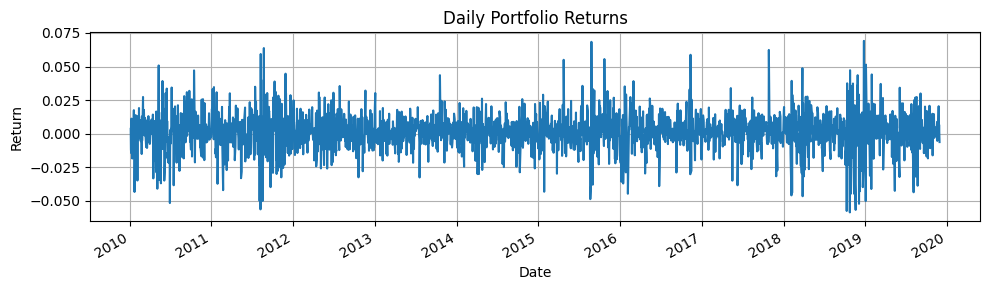

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
portfolio_returns.plot(ax=ax)
ax.set_title("Daily Portfolio Returns")
ax.set_ylabel("Return")
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# === 4. Normality tests: Shapiro–Wilk and KS ===
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()

print(f"Sample mean: {mean:.6f}")
print(f"Sample std : {std_dev:.6f}")

# Shapiro-Wilk test (use a subset of 5000 points; since Shapiro is O(n^2))

returns_for_shapiro = portfolio_returns.sample(n=min(len(portfolio_returns), 5000), random_state=42)
shapiro_stat, shapiro_p = stats.shapiro(returns_for_shapiro)

print("\nShapiro–Wilk test:")
print(f"  W-statistic: {shapiro_stat:.4f}")
print(f"  p-value    : {shapiro_p:.4g}")

Sample mean: 0.001033
Sample std : 0.013637

Shapiro–Wilk test:
  W-statistic: 0.9610
  p-value    : 2.257e-25


p<0.05; reject null hypothesis of normality

Let us instead fit it to a t-distribution

In [8]:
# Fit Student-t to portfolio returns
df_hat, loc_hat, scale_hat = stats.t.fit(portfolio_returns)

print("Fitted Student-t parameters:")
print("df   =", df_hat)
print("loc  =", loc_hat)
print("scale=", scale_hat)
# === 4. KS ===

# KS test vs fitted Student's t distribution
ks_stat, ks_p = stats.kstest(portfolio_returns, "t", args=(df_hat, loc_hat, scale_hat))

print("\nKolmogorov–Smirnov test vs fitted t:")
print(f"  KS-statistic: {ks_stat:.4f}")
print(f"  p-value     : {ks_p:.4g}")

Fitted Student-t parameters:
df   = 3.4618741238518727
loc  = 0.001341497744372568
scale= 0.009426531456289827

Kolmogorov–Smirnov test vs fitted t:
  KS-statistic: 0.0148
  p-value     : 0.6404


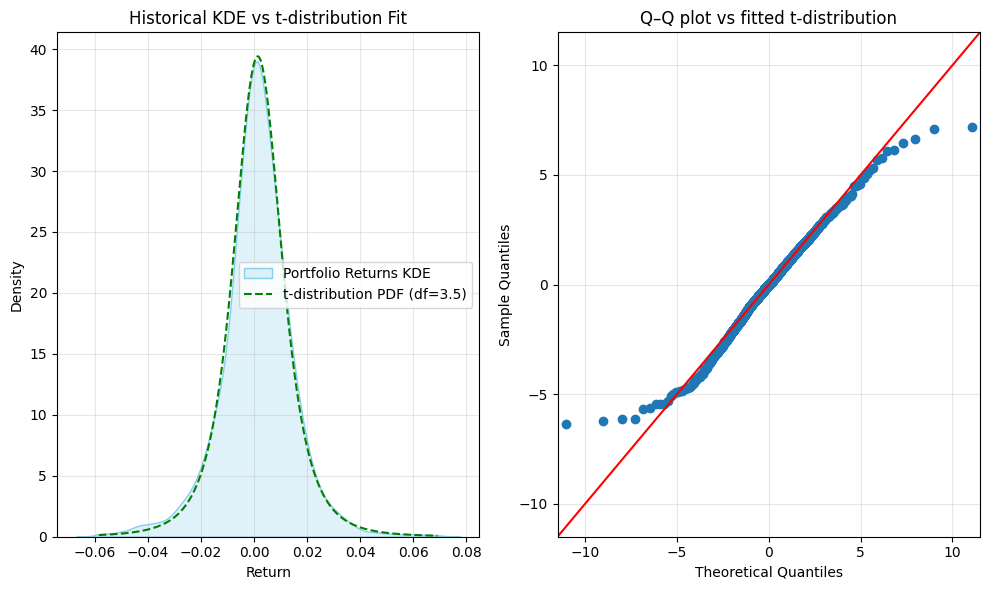

In [9]:
# Compare fit with KDE and normal
fig,ax=plt.subplots(1,2, figsize=(10,6))

x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio Returns KDE',ax=ax[0])
#sns.histplot(portfolio_returns, kde=True, stat='density', color='skyblue', label='Portfolio Returns',ax =ax[0])
ax[0].plot(x, stats.t.pdf(x, df=df_hat, loc=loc_hat, scale=scale_hat), 'g--', label=f't-distribution PDF (df={df_hat:.1f})')
ax[0].set_title("Historical KDE vs t-distribution Fit")
ax[0].set_xlabel("Return")
ax[0].set_ylabel("Density")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# 2. Q–Q plot vs fitted t
sm.qqplot(
    portfolio_returns,
    dist=stats.t,           # use Student-t instead of normal
    fit=True,
    line="45",               # 45° reference line
    ax=ax[1]
)
ax[1].set_title("Q–Q plot vs fitted t-distribution")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



The t-distribution with df=3.5 provides a reasonable fit overall, though the extreme negative tail is still heavier than the model suggests.

Lets Calculate the VaR and CVaR

In [10]:
# Convert returns to losses (positive means we lose money)
losses = -portfolio_returns

alpha_values = [0.95, 0.99]

for alpha in alpha_values:
    # Historical VaR: alpha-quantile of losses
    var_alpha = np.quantile(losses, alpha)

    # Historical CVaR: average loss beyond VaR
    tail_losses = losses[losses >= var_alpha]
    cvar_alpha = tail_losses.mean()

    print(f"{int(alpha*100)}% Historical VaR:  {var_alpha:.4%}")
    print(f"{int(alpha*100)}% Historical CVaR: {cvar_alpha:.4%}")
    print()


95% Historical VaR:  2.1539%
95% Historical CVaR: 3.2190%

99% Historical VaR:  3.9845%
99% Historical CVaR: 4.7449%



In [11]:
n_sim = 100_000  # number of Monte Carlo samples for the t model

for alpha in alpha_values:
    # Parametric VaR for returns: t-quantile
    var_return_t = stats.t.ppf(1 - alpha, df=df_hat, loc=loc_hat, scale=scale_hat)
    var_loss_t = -var_return_t

    # Parametric CVaR approximation using Monte Carlo samples
    simulated_returns_t = stats.t.rvs(df_hat, loc_hat, scale_hat, size=n_sim)
    simulated_losses_t = -simulated_returns_t

    var_sim = np.quantile(simulated_losses_t, alpha)
    tail_sim = simulated_losses_t[simulated_losses_t >= var_sim]
    cvar_loss_t = tail_sim.mean()

    print(f"{int(alpha*100)}% Student-t VaR (theoretical):  {var_loss_t:.4%}")
    print(f"{int(alpha*100)}% Student-t CVaR (MC approx.): {cvar_loss_t:.4%}")
    print()


95% Student-t VaR (theoretical):  1.9686%
95% Student-t CVaR (MC approx.): 3.1804%

99% Student-t VaR (theoretical):  3.7215%
99% Student-t CVaR (MC approx.): 5.5569%



So far we:

- created a **portfolio** from multiple assets, then
- worked only with the **aggregate portfolio return series**.
 
If all the stock returns individually follow a t with nearly same d.o.f.s, we would be justified in using a multivariate t dist. to model the total returns. Lets test this:

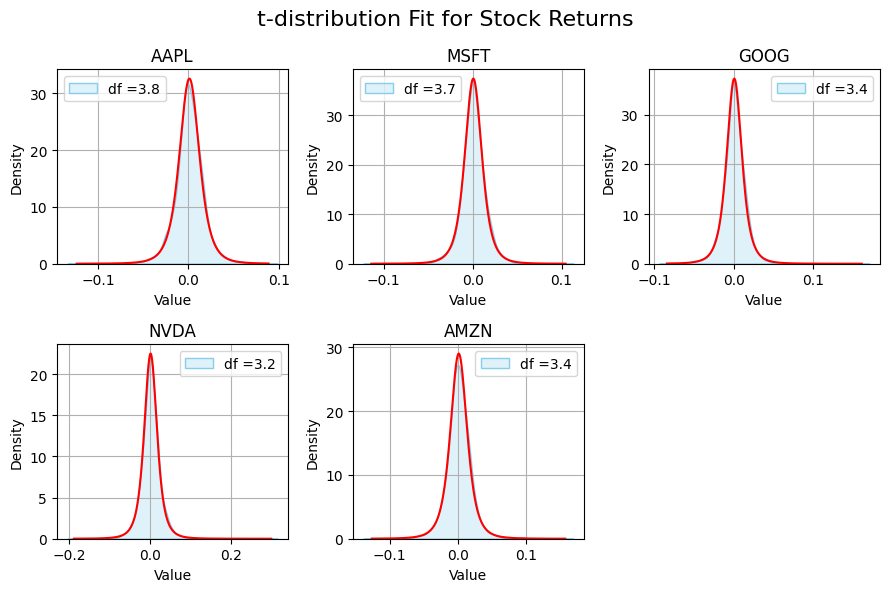

In [12]:
def plot_t_distribution_fit(returns):
    """
    Plot the t-distribution fit against the data. """
    # Create a 2x3 grid but remove the last empty subplot
    fig, ax = plt.subplots(2, 3, figsize=(9, 6))
    plt.suptitle('t-distribution Fit for Stock Returns', fontsize=16)
    # Flatten the axis array for easier indexing
    ax = ax.flatten()
    
    for i, stock in enumerate(tickers):
        data = returns[stock]
        df, loc, scale = stats.t.fit(data)
        x = np.linspace(data.min(), data.max(), 1000)
        
        sns.kdeplot(data, fill=True, color='skyblue', label='Data KDE', ax=ax[i])
        ax[i].plot(x, stats.t.pdf(x, df, loc=loc, scale=scale), 'r-', label=f't-distribution PDF (df={df:.1f})')
        ax[i].set_title(f'{stock}')
        ax[i].set_xlabel('Value')
        ax[i].set_ylabel('Density')
        ax[i].legend([f'df ={df:.1f}'])
        ax[i].grid(True)
    
    # Hide the last empty subplot
    ax[5].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_t_distribution_fit(asset_returns)

In [14]:
# Individual t-distribution simulation approach
print("=== Individual t-Distribution Simulation Approach ===\n")

# Step 1: Fit t-distribution to each stock and store parameters
individual_t_params = {}
print("Fitting t-distributions to individual stocks:")
print("Stock\tdf\tloc\t\tscale")
print("-" * 40)

for stock in tickers:
    df_stock, loc_stock, scale_stock = stats.t.fit(asset_returns[stock])
    individual_t_params[stock] = {'df': df_stock, 'loc': loc_stock, 'scale': scale_stock}
    print(f"{stock}\t{df_stock:.2f}\t{loc_stock:.6f}\t{scale_stock:.6f}")

print(f"\nDegrees of freedom range: {min([params['df'] for params in individual_t_params.values()]):.2f} - {max([params['df'] for params in individual_t_params.values()]):.2f}")

=== Individual t-Distribution Simulation Approach ===

Fitting t-distributions to individual stocks:
Stock	df	loc		scale
----------------------------------------
AAPL	3.77	0.001174	0.011470
MSFT	3.74	0.000748	0.009986
GOOG	3.41	0.000787	0.009959
NVDA	3.25	0.001041	0.016434
AMZN	3.38	0.001204	0.012792

Degrees of freedom range: 3.25 - 3.77


In [16]:
# Step 2: Monte Carlo simulation using individual t-distributions
print("\n=== Monte Carlo Simulation with Individual t-Distributions ===")

n_simulations = 100_000
confidence_level = 0.95

# Initialize array to store simulated portfolio returns
portfolio_returns_individual_t = np.zeros(n_simulations)

# Set random seed for reproducibility
np.random.seed(42)

# For each simulation, generate returns for all stocks and compute portfolio return
for i in range(n_simulations):
    daily_returns = np.zeros(len(tickers))
    
    # Generate return for each stock using its individual t-distribution
    for j, stock in enumerate(tickers):
        params = individual_t_params[stock]
        # Generate one random sample from the t-distribution
        daily_returns[j] = stats.t.rvs(df=params['df'], 
                                loc=params['loc'], 
                                scale=params['scale'])
    
    # Compute portfolio return (equal weights)
    portfolio_returns_individual_t[i] = np.dot(daily_returns, weights)

# Calculate VaR and CVaR
individual_t_VaR = np.percentile(portfolio_returns_individual_t, (1-confidence_level)*100)
individual_t_CVaR = portfolio_returns_individual_t[portfolio_returns_individual_t <= individual_t_VaR].mean()

print(f"Individual t-Distribution Simulation Results ({confidence_level*100:.0f}% confidence):")
print(f"VaR: {-individual_t_VaR:.4f}")
print(f"CVaR: {-individual_t_CVaR:.4f}")
print(f"Number of simulations: {n_simulations:,}")

# Compare with historical measures
hist_VaR = np.percentile(portfolio_returns, (1-confidence_level)*100)
hist_CVaR = portfolio_returns[portfolio_returns <= hist_VaR].mean()

print(f"\nComparison with Historical:")
print(f"Historical VaR: {-hist_VaR:.4f}")
print(f"Historical CVaR: {-hist_CVaR:.4f}")
print(f"Difference VaR: {individual_t_VaR - hist_VaR:.4f}")
print(f"Difference CVaR: {individual_t_CVaR - hist_CVaR:.4f}")


=== Monte Carlo Simulation with Individual t-Distributions ===
Individual t-Distribution Simulation Results (95% confidence):
VaR: 0.0122
CVaR: 0.0178
Number of simulations: 100,000

Comparison with Historical:
Historical VaR: 0.0215
Historical CVaR: 0.0322
Difference VaR: 0.0094
Difference CVaR: 0.0143


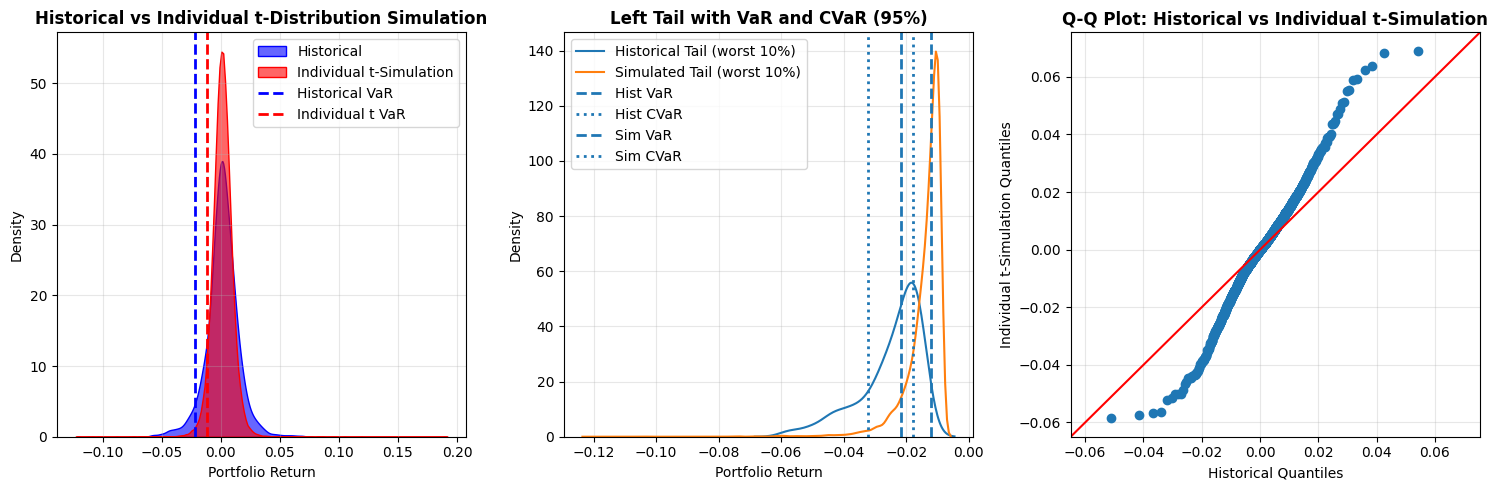

In [ ]:

from statsmodels.graphics.gofplots import qqplot_2samples
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Distribution comparison
ax1 = axes[0]
sns.kdeplot(portfolio_returns, fill=True, color='blue', alpha=0.6, label='Historical', ax=ax1)
sns.kdeplot(portfolio_returns_individual_t, fill=True, color='red', alpha=0.6, label='Individual t-Simulation', ax=ax1)

# Add VaR lines
ax1.axvline(hist_VaR, color='blue', linestyle='--', linewidth=2, label='Historical VaR')
ax1.axvline(individual_t_VaR, color='red', linestyle='--', linewidth=2, label='Individual t VaR')

ax1.set_title('Historical vs Individual t-Distribution Simulation', fontweight='bold')
ax1.set_xlabel('Portfolio Return')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Q-Q plot
plt =  axes[2]  # reuse your existing axes

qqplot_2samples(
    portfolio_returns,                # sample 1: historical
    portfolio_returns_individual_t,   # sample 2: simulated
    line='45',                        # 45° reference line
    ax=plt
)

plt.set_title('Q-Q Plot: Historical vs Individual t-Simulation', fontweight='bold')
plt.set_xlabel('Historical Quantiles')
plt.set_ylabel('Individual t-Simulation Quantiles')
plt.grid(True, alpha=0.3)

# Plot 3: Tail comparison with VaR and CVaR
ax3 = axes[1]
# Worst 10% of returns
hist_tail = np.sort(portfolio_returns)[:int(0.1 * len(portfolio_returns))]
sim_tail = np.sort(portfolio_returns_individual_t)[:int(0.1 * len(portfolio_returns_individual_t))]

sns.kdeplot(hist_tail, label='Historical Tail (worst 10%)', ax=ax3)
sns.kdeplot(sim_tail, label='Simulated Tail (worst 10%)', ax=ax3)

# Add VaR / CVaR lines
# You can tweak linestyles so you can distinguish VaR vs CVaR
ax3.axvline(hist_VaR, linestyle='--', linewidth=2, label='Hist VaR')
ax3.axvline(hist_CVaR, linestyle=':',  linewidth=2, label='Hist CVaR')

ax3.axvline(individual_t_VaR, linestyle='--', linewidth=2, label='Sim VaR')
ax3.axvline(individual_t_CVaR, linestyle=':',  linewidth=2, label='Sim CVaR')

ax3.set_title('Left Tail with VaR and CVaR (95%)', fontweight='bold')
ax3.set_xlabel('Portfolio Return')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.tight_layout()


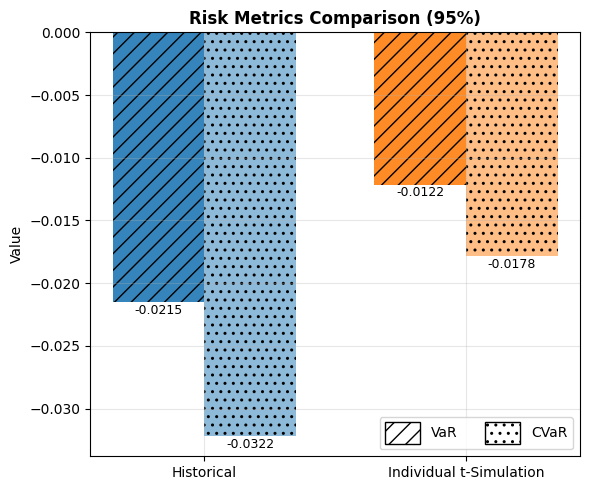

In [49]:
from matplotlib.patches import Patch

fig, ax4 = plt.subplots(1, 1, figsize=(6, 5))

methods = ['Historical', 'Individual t-Simulation']
vars_comparison  = [hist_VaR,  individual_t_VaR]
cvars_comparison = [hist_CVaR, individual_t_CVaR]

x = np.arange(len(methods))
width = 0.35

# Same colours per method, different hatches for VaR vs CVaR
bars_VaR = ax4.bar(
    x - width/2, vars_comparison, width,
    color=['tab:blue', 'tab:orange'],
    hatch='//', alpha=0.9
)
bars_CVaR = ax4.bar(
    x + width/2, cvars_comparison, width,
    color=['tab:blue', 'tab:orange'],
    hatch='..', alpha=0.5
)

ax4.set_title('Risk Metrics Comparison (95%)', fontweight='bold')
ax4.set_ylabel('Value')
ax4.set_xticks(x)
ax4.set_xticklabels(methods)
ax4.grid(True, alpha=0.3)

# Value labels
for bar in list(bars_VaR) + list(bars_CVaR):
    h = bar.get_height()
    ax4.annotate(
        f'{h:.4f}',
        xy=(bar.get_x() + bar.get_width()/2, h-0.0015),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom', fontsize=9
    )

# Custom legend: colours = method, hatch = metric
legend_elements = [
    #Patch(facecolor='tab:blue',   label='Historical'),
    #Patch(facecolor='tab:orange', label='Individual t-Sim'),
    Patch(facecolor='None', edgecolor='k', hatch='//', label='VaR'),
    Patch(facecolor='None', edgecolor='k', hatch='..', label='CVaR'),
]

ax4.legend(handles=legend_elements, ncol=2, frameon=True,    handlelength=2.5,   # make legend symbols wider
    handleheight=2.0,   # and taller
    labelspacing=0.8,)

plt.tight_layout()
plt.show()


the individual t-distribution approach is clearly more optimistic about tail risk than what actually happened in the data. this particular modelling choice is underestimating risk, relative to history.
The individual-t Monte Carlo reproduces the central part of the return distribution reasonably well, but its left tail is much thinner than in the historical data. This leads to substantially lower simulated 95% VaR and CVaR in magnitude, meaning the model underestimates extreme loss risk compared to what has actually been observed.

### Comparison: Historical vs Individual t Monte Carlo (95% VaR/CVaR)

Using 100,000 Monte Carlo simulations where each stock return is sampled
independently from its fitted univariate Student-t distribution, we obtain:

- **Model-based (individual t) VaR (95%)**: 1.22%
- **Model-based (individual t) CVaR (95%)**: 1.78%

By contrast, the **historical** estimates from the actual return series are:

- **Historical VaR (95%)**: 2.15%
- **Historical CVaR (95%)**: 3.22%

Thus, the individual-t Monte Carlo approach produces substantially lower
tail-risk estimates (VaR and especially CVaR) than the historical data.
This indicates that, despite using heavy-tailed marginals, the model still
underestimates extreme joint losses compared to what has been observed
in the sample. In the next step, we move to a multivariate t model that
explicitly captures both heavy tails and cross-asset dependence.



Now we briefly look at how **correlations between assets** affect portfolio
VaR in a simple **multivariate** setting.

We compare two models for asset returns:

1. **Independent assets**: off-diagonal covariances set to zero  
2. **Correlated assets**: use the empirical covariance matrix

In both cases we:

- simulate many daily return vectors,
- build portfolio returns using the same weights,
- compute VaR from the simulated loss distribution.


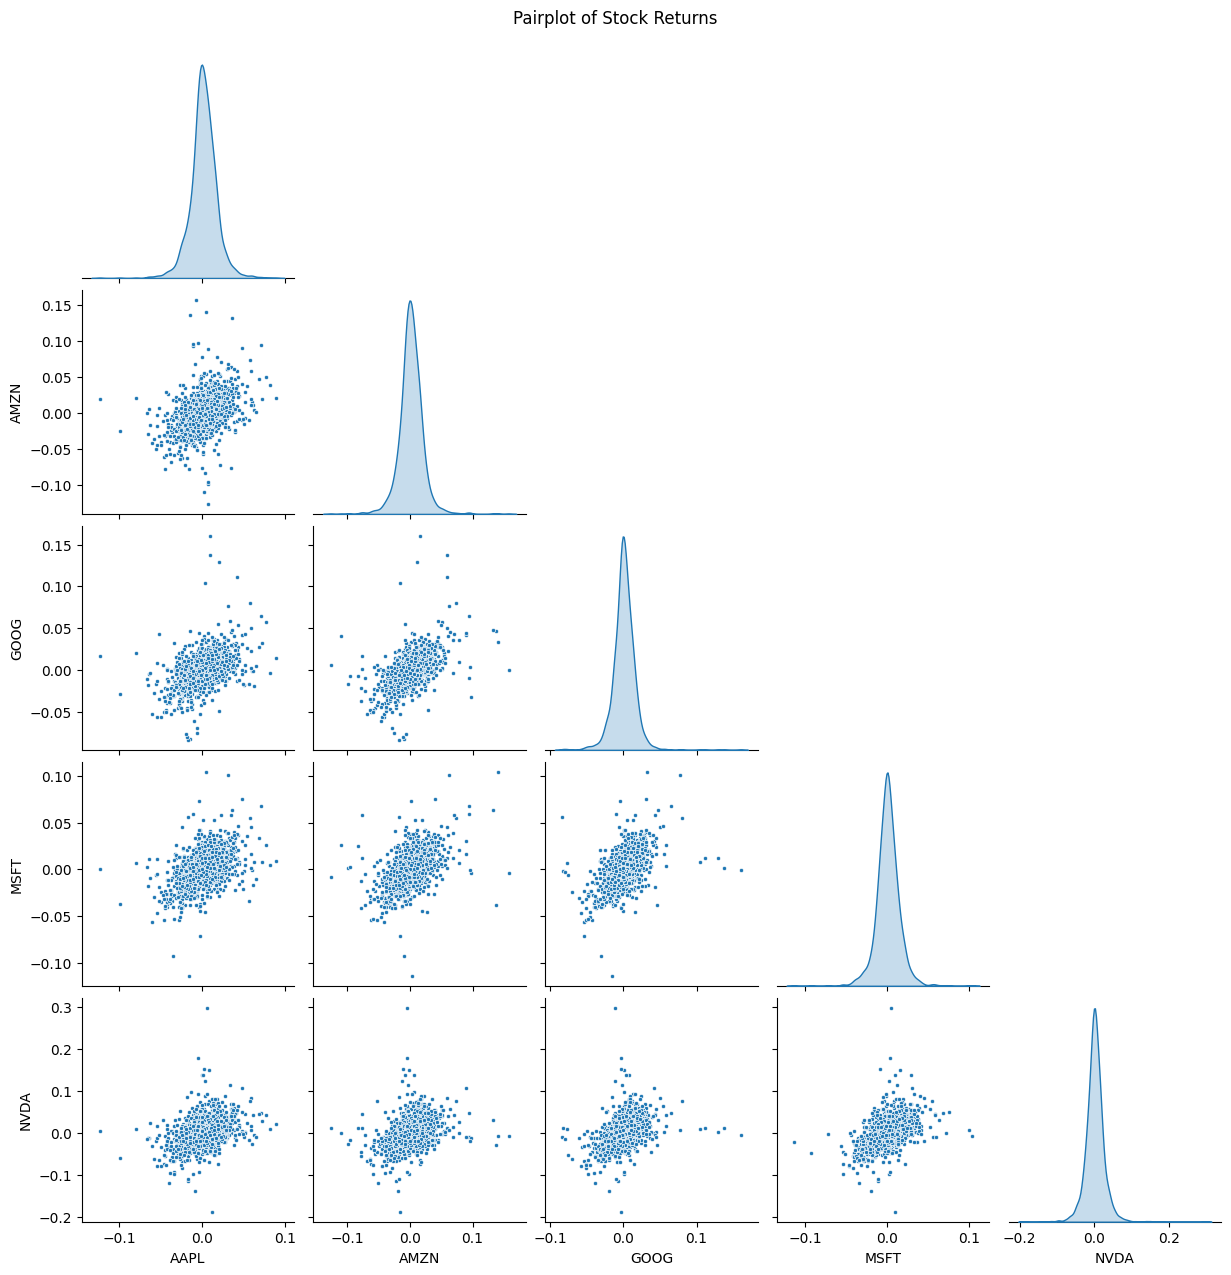

In [52]:
sns.pairplot(asset_returns, diag_kind='kde', markers='.',corner=True)
plt.suptitle('Pairplot of Stock Returns', y=1.02)
plt.show()

In [55]:
mu_vec = asset_returns.mean().values      # vector of means (daily)
cov_mat = asset_returns.cov().values      # empirical covariance matrix
print("Mean vector:", mu_vec)
print("Covariance matrix:\n", cov_mat)

Mean vector: [0.00105787 0.00123309 0.00069205 0.00083576 0.00134523]
Covariance matrix:
 [[0.0002643  0.00012643 0.00011665 0.00010674 0.00016084]
 [0.00012643 0.00038291 0.00016867 0.00013734 0.00018577]
 [0.00011665 0.00016867 0.00023875 0.00012001 0.0001615 ]
 [0.00010674 0.00013734 0.00012001 0.00020622 0.00016637]
 [0.00016084 0.00018577 0.0001615  0.00016637 0.00065636]]


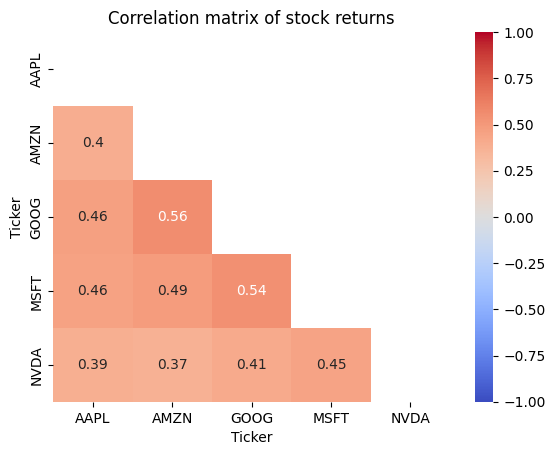

In [56]:
corr_mat = asset_returns.corr()
mask= np.triu(np.ones_like(corr_mat, dtype=bool)) # remove upper triangle

sns.heatmap(corr_mat, annot=True,mask=mask, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix of stock returns")
plt.show()

The portfolio does diversify risk somewhat, because correlations are < 1. But because they’re all clearly positive, there is still substantial common market/tech factor risk i.e, big market moves will hit them together.

In [57]:
# Diagonal covariance: keep variances, drop covariances
cov_indep = np.diag(np.diag(cov_mat))
print("Diagonal 'independent' covariance matrix:\n", cov_indep)

Diagonal 'independent' covariance matrix:
 [[0.0002643  0.         0.         0.         0.        ]
 [0.         0.00038291 0.         0.         0.        ]
 [0.         0.         0.00023875 0.         0.        ]
 [0.         0.         0.         0.00020622 0.        ]
 [0.         0.         0.         0.         0.00065636]]


In [67]:
nu = 3.5
n_sim = 100_000
def simulate_mvt(mu, Sigma, df, size):
    """
    Multivariate t via normal + scaled chi-square:
    X = mu + Z / sqrt(U/df),
    Z ~ N(0, Sigma), U ~ chi2(df)
    """
    d = len(mu)
    # Z: correlated normals
    Z = np.random.multivariate_normal(np.zeros(d), Sigma, size=size)
    # U: chi-square(df) -> scale each row
    U = np.random.chisquare(df, size=size)
    # broadcast scaling
    X = mu + Z / np.sqrt(U[:, None] / df)
    return X
sim_corr  = simulate_mvt(mu_vec, cov_mat,   df=nu, size=n_sim)
sim_indep = simulate_mvt(mu_vec, cov_indep, df=nu, size=n_sim)

port_corr  = sim_corr.dot(weights)
port_indep = sim_indep.dot(weights)

loss_corr  = -port_corr
loss_indep = -port_indep

var_corr  = np.quantile(loss_corr,  alpha)
var_indep = np.quantile(loss_indep, alpha)

print(f"95% VaR (MV-t, with correlations):      {var_corr:.4%}")
print(f"95% VaR (MV-t, assuming independence): {var_indep:.4%}")
# CVaR (Expected Shortfall)
cvar_corr  = loss_corr[loss_corr >= var_corr].mean()
cvar_indep = loss_indep[loss_indep >= var_indep].mean()

print(f"95% VaR (MV-t, with correlations):        {var_corr:.4%}")
print(f"95% CVaR (MV-t, with correlations):       {cvar_corr:.4%}")
print(f"95% VaR (MV-t, assuming independence):    {var_indep:.4%}")
print(f"95% CVaR (MV-t, assuming independence):   {cvar_indep:.4%}")


95% VaR (MV-t, with correlations):      2.9096%
95% VaR (MV-t, assuming independence): 1.7516%
95% VaR (MV-t, with correlations):        2.9096%
95% CVaR (MV-t, with correlations):       4.5797%
95% VaR (MV-t, assuming independence):    1.7516%
95% CVaR (MV-t, assuming independence):   2.7904%


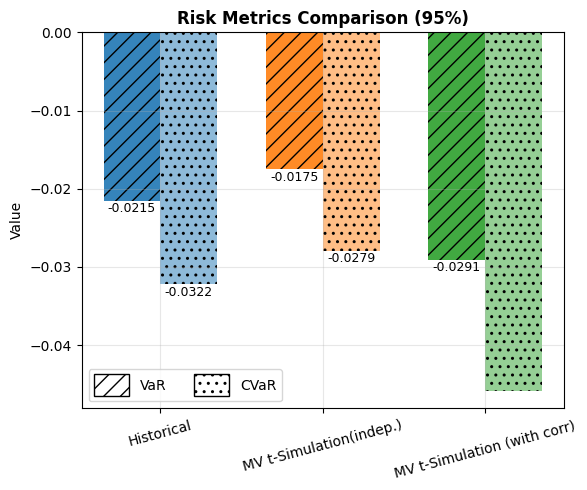

In [74]:
from matplotlib.patches import Patch

fig, ax4 = plt.subplots(1, 1, figsize=(6, 5))

methods = ['Historical', 'MV t-Simulation(indep.)','MV t-Simulation (with corr)']
vars_comparison  = [hist_VaR, -var_indep, -var_corr]
cvars_comparison = [hist_CVaR, -cvar_indep, -cvar_corr]

x = np.arange(len(methods))
width = 0.35
colors = ['tab:blue', 'tab:orange','tab:green']

# Same colours per method, different hatches for VaR vs CVaR
bars_VaR = ax4.bar(
    x - width/2, vars_comparison, width,
    color=colors,
    hatch='//', alpha=0.9
)
bars_CVaR = ax4.bar(
    x + width/2, cvars_comparison, width,
    color=colors,
    hatch='..', alpha=0.5
)

ax4.set_title('Risk Metrics Comparison (95%)', fontweight='bold')
ax4.set_ylabel('Value')
ax4.set_xticks(x)
ax4.set_xticklabels(methods, rotation=15)
ax4.grid(True, alpha=0.3)

# Value labels
for bar in list(bars_VaR) + list(bars_CVaR):
    h = bar.get_height()
    ax4.annotate(
        f'{h:.4f}',
        xy=(bar.get_x() + bar.get_width()/2, h-0.0024),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom', fontsize=9
    )

# Custom legend: colours = method, hatch = metric
legend_elements = [
    #Patch(facecolor='tab:blue',   label='Historical'),
    #Patch(facecolor='tab:orange', label='Individual t-Sim'),
    Patch(facecolor='None', edgecolor='k', hatch='//', label='VaR'),
    Patch(facecolor='None', edgecolor='k', hatch='..', label='CVaR'),
]

ax4.legend(handles=legend_elements, ncol=2, frameon=True,    handlelength=2.5,   # make legend symbols wider
    handleheight=2.0,   # and taller
    labelspacing=0.8,)

plt.tight_layout()
plt.show()


Moving from independent t marginals to a multivariate t with a common scale factor and finally to a correlated multivariate t steadily increases 95% VaR and CVaR. This shows how both tail dependence and linear correlations amplify portfolio tail risk beyond what is implied by independent heavy-tailed assets.

### Summary

- We built a small equity portfolio and computed **historical VaR and CVaR**
  directly from the empirical distribution of daily portfolio returns.
- A **Student-t** distribution allows for heavier tails, typically leading to
  larger (more conservative) VaR and CVaR estimates, especially at high
  confidence levels.
- Using a simple **multivariate t** model, we saw that **correlations
  between assets** affect portfolio VaR: assuming independence can misstate
  risk compared to a model that uses the empirical covariance matrix.
